In [1]:
### Python
import os
import random
import time
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
#import seaborn as sns

### Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
import segmentation_models_pytorch as smp
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchsummary import summary

### Others
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

### Images
import cv2
from PIL import Image

#my classes
import dataset as customdataset
import my_functions
import models

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [3]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

categorie = "corn"

train_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_train_positions.csv" 
train_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_train_info.csv"
train_data_path = path + f"{categorie}_coco" 

test_csv_positions  = path + f"{categorie}_coco/{categorie}_kernel_test_positions.csv" 
test_csv_info       = path + f"{categorie}_coco/{categorie}_kernel_test_info.csv"
test_data_path = path + f"{categorie}_coco" 

In [4]:
### Define dataset
train_dataset = customdataset.CustomImageDataset(train_csv_positions,train_csv_info,train_data_path,
                                           threshold=1e-4,re_scale=1e5,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)

test_dataset = customdataset.CustomImageDataset(test_csv_positions,test_csv_info,test_data_path,
                                           threshold=1e-4,re_scale=1e5,
                                           img_transforms=transforms.ToTensor(),
                                           mask_transforms=transforms.ToTensor(),
                                           I_M_transforms=None)

**Datasets statistics**

Plot a few images:

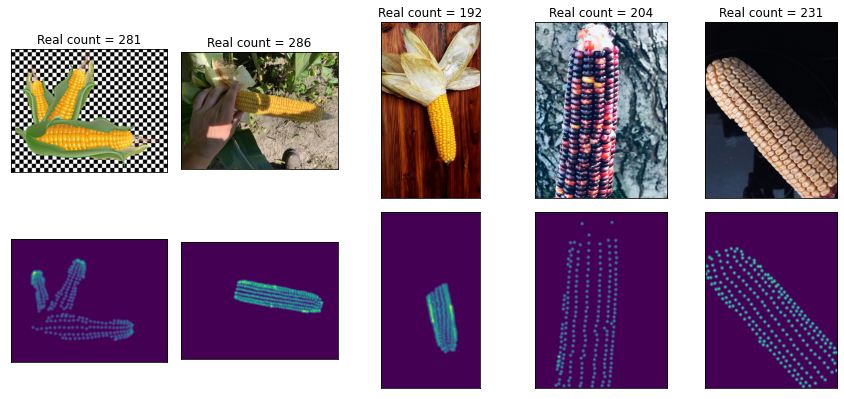

In [5]:
my_functions.plot_dataset_images_and_masks(train_dataset)

Estimate mean and standard deviation by channel of each dataset

In [6]:
print("max",train_dataset[0][0].amax(axis= [1,2]))
print("min",train_dataset[0][0].amin(axis= [1,2]))

train_mean, train_std = my_functions.dataset_mean_std(train_dataset)
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.
#train_mean, train_std =train_mean/255, train_std/255
# output
print('mean: '  + str(train_mean))
print('std:  '  + str(train_std))

max tensor([1., 1., 1.])
min tensor([0., 0., 0.])
mean: tensor([0.5070, 0.4383, 0.3099])
std:  tensor([0.2985, 0.2740, 0.2705])


**Split training dataset into train and validation**

In [7]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.80)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 193


In [8]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 193
Number validation examples: 49
Number test examples: 62


In [9]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set


**Data transforms for data augmentation**


In [10]:
### Define the data augmentation transforms
train_img_transforms = transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.RandomAutocontrast(p=0.4),
                                        torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0.1, hue=0.1),
                                        
                                        transforms.Resize((300,300)),
                                        transforms.Normalize(train_mean, train_std),
                                        ])

geometric_transforms = transforms.Compose([
                                           customdataset.MyRotations(),
                                          ])

test_validation_img_transforms = transforms.Compose([
                                                     torchvision.transforms.ToTensor(),
                                                     transforms.Resize((300,300)),
                                                     transforms.Normalize(train_mean, train_std),
                                                     ])

lbl_transforms = transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                     transforms.Resize((300,300)),
                                     ])

**Update dataset transforms and define iterators for the datasets**

In [11]:
### Update transforms for the datasets and the corresponding iterators
# Train dataset
train_dataset.dataset.I_M_transforms    = geometric_transforms
train_dataset.dataset.img_transforms    = train_img_transforms
train_dataset.dataset.mask_transforms = lbl_transforms
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=0)

# Validation dataset
validation_dataset.dataset.img_transforms    = test_validation_img_transforms
validation_dataset.dataset.mask_transforms  = lbl_transforms
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)

# test dataset
test_dataset.img_transforms    = test_validation_img_transforms
test_dataset.mask_transforms = lbl_transforms
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


Lets check the dataloaders

In [12]:
start_time = time.time()
train_images, train_masks, shape,count = next(iter(train_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 16.62 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

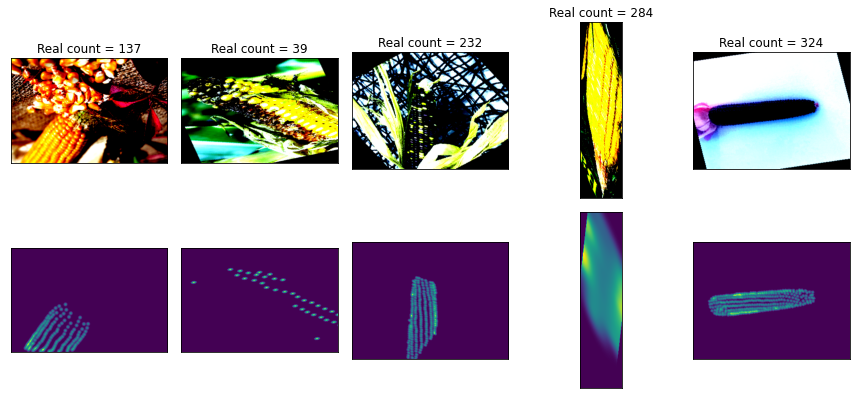

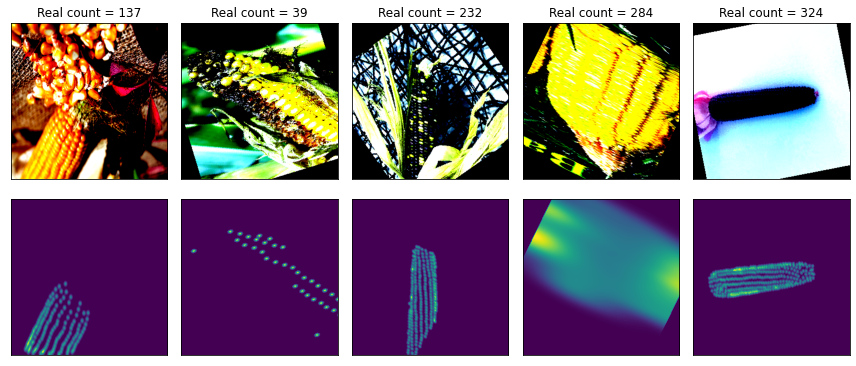

In [13]:
my_functions.reconstruct_plot_images_masks(train_images, train_masks, shape,count)
my_functions.Non_reconstruct_plot_images_masks(train_images, train_masks, shape,count)

In [14]:
start_time = time.time()
test_images, test_masks, shape,count = next(iter(test_dataloader))
end_time = time.time()
print(f"Dataloader Time: {end_time-start_time:.2f} s")

Dataloader Time: 7.56 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

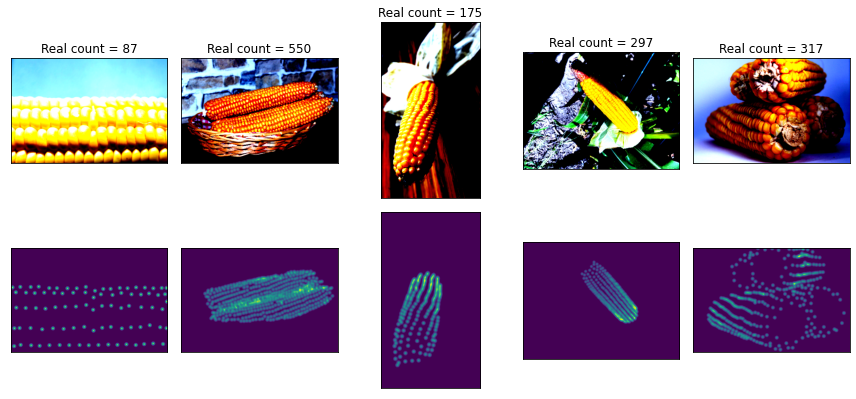

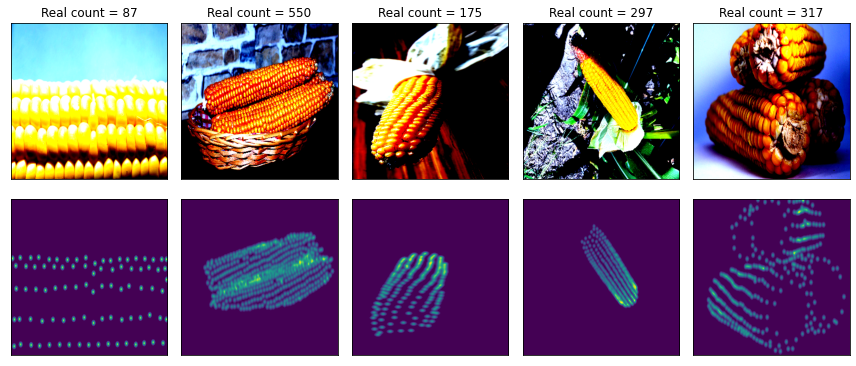

In [15]:
my_functions.reconstruct_plot_images_masks(test_images, test_masks, shape,count)
my_functions.Non_reconstruct_plot_images_masks(test_images, test_masks, shape,count)

# Network architecture

**This simple model doesnt work if the image input is normalizer to the interval [0,1]**

In [16]:
model = models.U_NET()

In [19]:
max_epochs        = 100
learning_rate     = 1e-4

In [20]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cpu


U_NET(
  (encoder): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(20, 30, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Conv2d(30, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Upsample(scale_factor=2.0, mode=bilinear)
    (2): ReLU(inplace=True)
    (3): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Upsample(scale_factor=2.0, mode=bilinear)
    (5): ReLU(inplace=True)
    (6): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1)

In [25]:
# Define a method for weights initialization
def weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.normal_(model.weight.data, -0.02, 0.02) # [zeros_, normal_, xavier_uniform_, xavier_normal_]
        nn.init.constant_(model.bias, 0.01)

In [26]:
# Apply initialization
model.apply(weights_init)

U_NET(
  (encoder): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(20, 30, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Conv2d(30, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Upsample(scale_factor=2.0, mode=bilinear)
    (2): ReLU(inplace=True)
    (3): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Upsample(scale_factor=2.0, mode=bilinear)
    (5): ReLU(inplace=True)
    (6): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1)

In [27]:
summary = summary(model, (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 150, 150]             280
       BatchNorm2d-2         [-1, 10, 150, 150]              20
              ReLU-3         [-1, 10, 150, 150]               0
            Conv2d-4           [-1, 20, 75, 75]           1,820
       BatchNorm2d-5           [-1, 20, 75, 75]              40
              ReLU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 30, 38, 38]           5,430
       BatchNorm2d-8           [-1, 30, 38, 38]              60
              ReLU-9           [-1, 30, 38, 38]               0
           Conv2d-10           [-1, 20, 38, 38]           5,420
         Upsample-11           [-1, 20, 76, 76]               0
             ReLU-12           [-1, 20, 76, 76]               0
           Conv2d-13           [-1, 10, 76, 76]           1,810
         Upsample-14         [-1, 10, 1

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 1/100 -- Epoch Time: 127.92 s
---------------------------------
Train -- Loss: 57000.820
Val -- Loss: 40523.648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


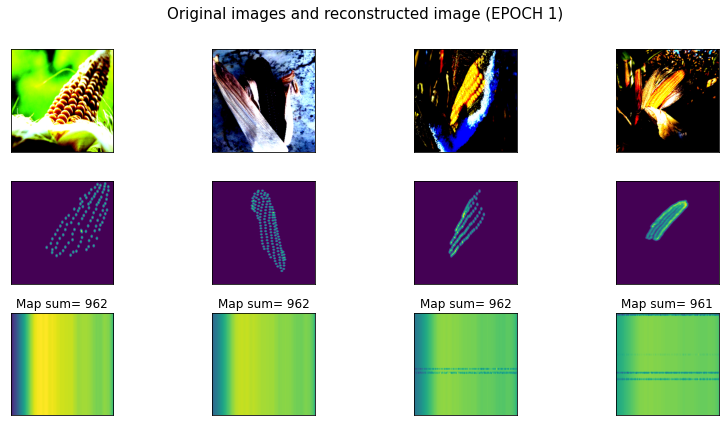

  2%|▏         | 2/100 [04:11<3:24:12, 125.03s/it]


Epoch: 2/100 -- Epoch Time: 122.09 s
---------------------------------
Train -- Loss: 54298.469
Val -- Loss: 40523.582

Epoch: 3/100 -- Epoch Time: 126.13 s
---------------------------------
Train -- Loss: 56507.949
Val -- Loss: 40523.523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


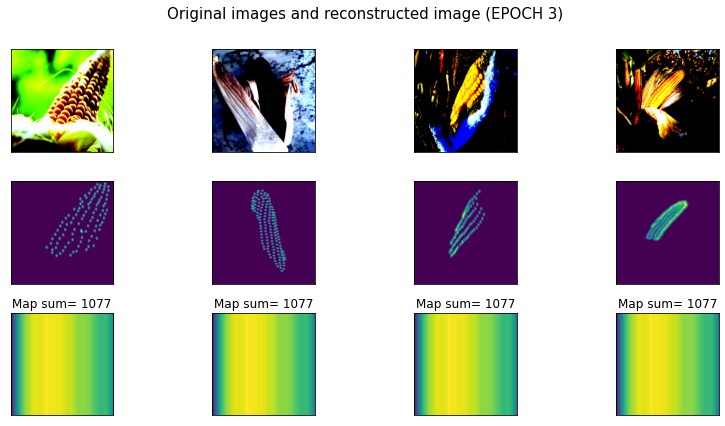

  4%|▍         | 4/100 [08:24<3:21:30, 125.95s/it]


Epoch: 4/100 -- Epoch Time: 125.28 s
---------------------------------
Train -- Loss: 58650.773
Val -- Loss: 40523.457


In [ ]:
#writer = SummaryWriter(f"./runs/geo_augmentation_lr_{learning_rate}_epochs_{max_epochs}_scale_{scale}_threshold_{1e-4}16")
writer = SummaryWriter()
train_loss, test_loss = my_functions.training_cycle(model,
                                                    device,
                                                    train_dataloader,
                                                    validation_dataloader,
                                                    validation_dataset,
                                                    loss_fn,
                                                    optimizer,
                                                    max_epochs,
                                                    writer,
                                                    verbose=True)
### To end TensorBoard writings
writer.close()

In [38]:
### Save model
os.makedirs('./Models', exist_ok=True)
torch.save(model.state_dict(), f'Models/First_U_NET.pth')

In [ ]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

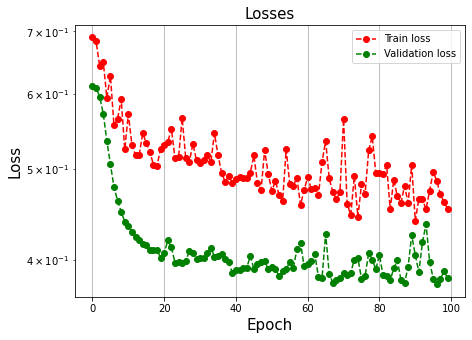

In [23]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

## Weights inspection

## Testing

In [ ]:
# Load network parameters
model.load_state_dict(torch.load(f'Models/geo_augmentation_lr_{learning_rate}_epochs_{max_epochs}_scale_{scale}12.pth'))

In [23]:
### Evaluation on test set
with torch.no_grad():
    for data in test_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, shapes, counts = data
        inputs = inputs.to(device)
        # forward 
        outputs = model(inputs, "Test")

### Statistics on the test set

In [24]:
idx = 2
input_image = inputs.detach().cpu().numpy()[idx]
predicted_map = outputs[idx]
original_map = labels[idx]

print("Predicted map:")
print("Shape",predicted_map.shape)
print("Min", predicted_map.min())
print("Maxp",predicted_map.max())
print("")
print("Original map:")
print("Shape",original_map.shape)
print("Min",original_map.min())
print("Maxp",original_map.max())

Predicted map:
Shape torch.Size([1, 300, 300])
Min tensor(0.0819)
Maxp tensor(27.1682)

Original map:
Shape torch.Size([1, 300, 300])
Min tensor(0.)
Maxp tensor(248.6062)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


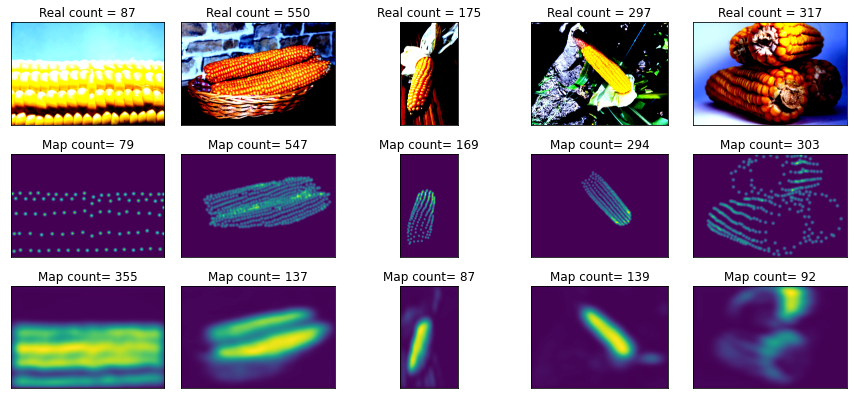

In [25]:
elements = [5,6,7,8,9]#random.sample([i for i in range(len(test_dataset))], 5)

fig, axs = plt.subplots(3, 5, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(5):
    idx = elements[i]
    ### Move the images to the right shapes
    UP = nn.Upsample(size=(shapes[0][idx],shapes[1][idx]),mode='bilinear')
    img = inputs[idx]#.numpy().transpose(1, 2, 0)
    img = img[None, :]
    img = UP(img)
    img = img[0].numpy().transpose(1, 2, 0)

    label = labels[idx]#.numpy().transpose(1, 2, 0)
    label = label[None, :]
    label = UP(label)
    label = label[0].numpy().transpose(1, 2, 0)
    
    map_ = outputs[idx]#.numpy().transpose(1, 2, 0)
    map_ = map_[None, :]
    map_ = UP(map_)
    map_ = map_[0].numpy().transpose(1, 2, 0) 
    
    # Plot the reconstructed image
    axs[i].imshow(img)
    axs[i].set_title(f"Real count = {counts[idx]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+5].imshow(label)
    axs[i+5].set_title(f"Map count= {int(label.sum()/1e5)}")
    axs[i+5].set_xticks([])
    axs[i+5].set_yticks([])
    axs[i+10].imshow(map_)
    axs[i+10].set_title(f"Map count= {int(map_.sum()/1e5)}")
    axs[i+10].set_xticks([])
    axs[i+10].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)